In [1]:
import pandas as pd
import numpy as np

import os
import unicodedata
import re
import json

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from prepare import prep_create_labels
from preprocess import prep_job_data, split_job_data, add_columns

# Wrangle the Data
- use functions from previous work to get a working train dataset

In [2]:
df = pd.read_json('indeed-data-jobs-FINAL.json')
df = prep_create_labels(df).reset_index(drop=True)
df = prep_job_data(df, 'job_description', extra_words=['job', 'description']).reset_index(drop=True)
df = add_columns(df)
df.sample(5)

/Users/brandmarz/data-science-projects/nlp-data-job-classifier/preprocess.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  .apply(lemmatize)
/Users/brandmarz/data-science-projects/nlp-data-job-classifier/preprocess.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stemmed'] = df[column].apply(basic_clean).apply(stem)
/Users/brandmarz/data-science-projects/nlp-data-job-classifier/preprocess.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

,job_title,company,location,is_remote,salary,post_date,date_accessed,job_description,label,clean,stemmed,lemmatized,words,doc_length
80,Associate Data Scientist,Øptimus Consulting,"Alexandria, VA 22314",0,,2 days ago,2021-03-05,"Job Description: Øptimus Consulting, a data sc...",DS,ptimus consulting data science software compan...,job descript ptimu consult a data scienc and s...,job description ptimus consulting a data scien...,"[ptimus, consulting, data, science, software, ...",286
356,Data Engineer,Thoughtwave software solutions Inc,"San Antonio, TX",1,,30+ days ago,2021-03-05,"Hello,Role : Data Engineer / (ONLY W2-USC,GC) ...",DE,hellorole data engineer w2uscgc location initi...,hellorol data engin onli w2uscgc locat initi r...,hellorole data engineer only w2uscgc location ...,"[hellorole, data, engineer, w2uscgc, location,...",57
423,Data Engineer II (Remote),eFinancial,"Tempe, AZ",1,,30+ days ago,2021-03-05,Who we are: Fidelity Life is a leading provide...,DE,fidelity life leading provider financial secur...,who we are fidel life is a lead provid of fina...,who we are fidelity life is a leading provider...,"[fidelity, life, leading, provider, financial,...",426
244,"Junior Data Analyst, Data & Analytics","LockerDome, Inc.",Remote,1,,2 days ago,2021-03-05,"LockerDome is an ad platform with a brain, des...",DA,lockerdome ad platform brain designed specific...,lockerdom is an ad platform with a brain desig...,lockerdome is an ad platform with a brain desi...,"[lockerdome, ad, platform, brain, designed, sp...",224
25,Data Scientist,HP,"Boise, ID 83714",0,,10 days ago,2021-03-05,"At HP, we are seeking to engineer experiences ...",DS,hp seeking engineer experience amaze create te...,at hp we are seek to engin experi that amaz to...,at hp we are seeking to engineer experience th...,"[hp, seeking, engineer, experience, amaze, cre...",393


In [3]:
train, validate, test = split_job_data(df)
print(f'train: {round(train.shape[0]/len(df),2)}')
print(f'validate: {round(validate.shape[0]/len(df),2)}')
print(f'test: {round(test.shape[0]/len(df),2)}')

train: 0.6
validate: 0.2
test: 0.2


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 426 entries, 420 to 531
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   label       426 non-null    object
 1   job_title   426 non-null    object
 2   company     426 non-null    object
 3   location    426 non-null    object
 4   is_remote   426 non-null    int64 
 5   clean       426 non-null    object
 6   words       426 non-null    object
 7   doc_length  426 non-null    int64 
dtypes: int64(2), object(6)
memory usage: 30.0+ KB


In [5]:
train.head()

,label,job_title,company,location,is_remote,clean,words,doc_length
420,DE,Data Engineer,"Stefanini, Inc","Richmond, VA",0,stefanini looking data engineer richmond va re...,"[stefanini, looking, data, engineer, richmond,...",216
250,DA,Financial Data Analyst (vehicle retail Domain),SILVERLINK TECHNOLOGIES LLC,"Bowling Green, KY",0,hiplease go let know interestjob title financi...,"[hiplease, go, let, know, interestjob, title, ...",64
426,DE,Data Engineer I or II - Can Be Remote Based On...,Associated Bank,"Milwaukee, WI",1,associated bank equal opportunity employer com...,"[associated, bank, equal, opportunity, employe...",366
170,DS,Associate Data Scientist,Gap Inc.,United States,0,gap inc brand bridge gap see world old navy de...,"[gap, inc, brand, bridge, gap, see, world, old...",337
581,MLE,Automation/Artificial Intelligence Machine Lea...,LOCKHEED MARTIN CORPORATION,"Littleton, CO 80125",0,coolest job planet lockheed martin space lockh...,"[coolest, job, planet, lockheed, martin, space...",499


### Number and % of Labels

In [6]:
labels = pd.concat([train.label.value_counts(),
                    train.label.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels

,n,percent
DA,112,0.262911
MLE,108,0.253521
DE,103,0.241784
DS,103,0.241784


### Break up Words by Label

In [7]:
# change words in each label into a list
da_words = ' '.join(df[df.label == 'DA'].clean)
ds_words = ' '.join(df[df.label == 'DS'].clean)
de_words = ' '.join(df[df.label == 'DE'].clean)
mle_words = ' '.join(df[df.label == 'MLE'].clean)
all_words = ' '.join(df.clean)

In [8]:
# eliminate white space before and after text, then split into individual word strings
da_words = re.sub(r'\s.\s', '', da_words).split()
ds_words = re.sub(r'\s.\s', '', ds_words).split()
de_words = re.sub(r'\s.\s', '', de_words).split()
mle_words = re.sub(r'\s.\s', '', mle_words).split()
all_words = re.sub(r'\s.\s', '', all_words).split()

In [15]:
#da_words

In [10]:
# transform each label string into a pandas Series
da_freq = pd.Series(da_words).value_counts()
ds_freq = pd.Series(ds_words).value_counts()
de_freq = pd.Series(de_words).value_counts()
mle_freq = pd.Series(mle_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [38]:
# combine all into a dataframe to work with
word_counts = (pd.concat([all_freq, ds_freq, da_freq, de_freq, mle_freq], axis=1, sort=True)
                .set_axis(['all', 'DS', 'DA', 'DE', 'MLE'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))
# add the proportion of each label in relation to all other categories
word_counts['prop_ds'] = word_counts['DS']/word_counts['all']
word_counts['prop_da'] = word_counts['DA']/word_counts['all']
word_counts['prop_de'] = word_counts['DE']/word_counts['all']
word_counts['prop_mle'] = word_counts['MLE']/word_counts['all']

word_counts.head()

,all,DS,DA,DE,MLE,prop_ds,prop_da,prop_de,prop_mle
000,8,0,5,1,2,0.000000,0.625000,0.125000,0.250000
00035586,1,0,1,0,0,0.000000,1.000000,0.000000,0.000000
01,4,0,1,1,2,0.000000,0.250000,0.250000,0.500000
01mar2021pimco,1,0,0,0,1,0.000000,0.000000,0.000000,1.000000
02,7,3,2,1,1,0.428571,0.285714,0.142857,0.142857


# What are the most frequently occurring words?

In [20]:
word_counts.sort_values(by='all', ascending=False).head()

,all,DS,DA,DE,MLE,prop_ds,prop_da,prop_de,prop_mle
data,6280,1694,1561,2243,782,0.269745,0.248567,0.357166,0.124522
experience,2566,677,452,710,727,0.263835,0.176150,0.276695,0.283320
team,1832,541,363,400,528,0.295306,0.198144,0.218341,0.288210
work,1701,452,414,408,427,0.265726,0.243386,0.239859,0.251029
learning,1502,352,38,81,1031,0.234354,0.025300,0.053928,0.686418


- `data` is obvious, we're dealing with data jobs
- `experience` may need to be a stop word, all jobs will require experience
- `team` and `work` are probably good works to have in a resume
- `learning` is interesting, we can look for it more with deeper exploration

# Are there any words that uniquely identify each label?

In [13]:
pd.concat([word_counts[word_counts.DA == 0].sort_values(by='DA').tail(6),
           word_counts[word_counts.DS == 0].sort_values(by='DS').tail(6),
           word_counts[word_counts.DE == 0].sort_values(by='DE').tail(6),
           word_counts[word_counts.MLE == 0].sort_values(by='MLE').tail(6),
          ])

,all,DS,DA,DE,MLE
farming,1,0,0,0,1
farsipersian,1,1,0,0,0
fascinated,1,1,0,0,0
fascinating,3,1,0,0,2
fan,12,6,0,0,6
zurich,1,1,0,0,0
explorer,1,0,0,0,1
exporting,1,0,0,0,1
exportingbuilding,1,0,1,0,0
exposurehandicapped,1,0,1,0,0


There isn't any word that significantly differentiates one label from the other. Also, most of these words are probably specific to the company, location, etc. so this probably won't be helpful

#  What is the Proportion of each label for the 20 most common words?

Text(0.5, 1.0, 'Proportion of DS vs DA vs DE vs MLE for the 20 most common words')

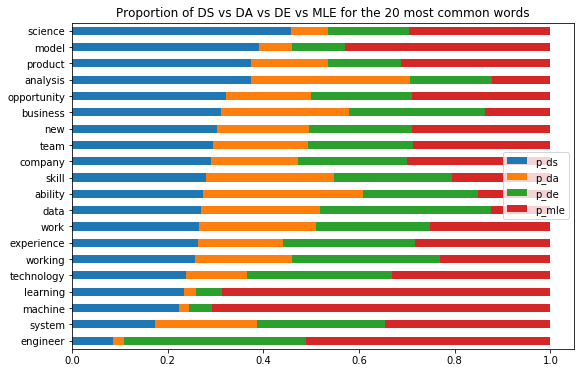

In [14]:
plt.rc('figure', figsize=(9,6))
(word_counts
 .assign(p_ds=word_counts.DS / word_counts['all'],
         p_da=word_counts.DA / word_counts['all'],
         p_de=word_counts.DE / word_counts['all'],
         p_mle=word_counts.MLE / word_counts['all'])
 .sort_values(by='all')
 [['p_ds', 'p_da', 'p_de', 'p_mle']]
 .tail(20)
 .sort_values('p_ds')
 .plot.barh(stacked=True))

plt.title('Proportion of DS vs DA vs DE vs MLE for the 20 most common words')

In [18]:
from wordcloud import WordCloud



# Does the length of the Job Description vary by Job Title?

In [22]:
train.groupby('label').doc_length.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
DA,112.0,246.196429,144.468697,28.0,133.00,220.0,322.25,755.0
DE,103.0,285.310680,138.392737,27.0,186.50,293.0,379.00,663.0
DS,103.0,317.805825,153.371078,49.0,190.00,305.0,393.50,925.0
MLE,108.0,299.981481,129.314221,31.0,205.75,307.0,374.00,695.0


(0, 1000)

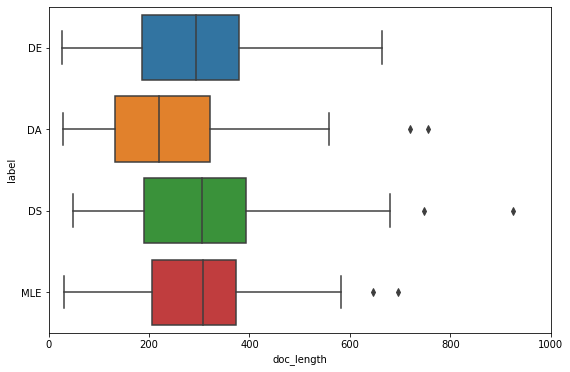

In [24]:
sns.boxplot(y=train.label, x=train.doc_length, orient="h")
plt.xlim(0, 1000)

# Do different job titles use a different number of unique words?

In [25]:
print("The number of words that occur n times: ")
word_counts['all'].value_counts().head(30)

The number of words that occur n times: 


1     10336
2      2094
3       996
4       579
5       451
6       335
7       302
8       191
9       178
11      149
10      148
12      132
13      124
14       96
16       79
17       68
15       68
19       58
18       53
20       50
22       41
21       41
23       40
25       40
27       37
26       32
28       32
24       32
31       32
34       26
Name: all, dtype: int64

In [39]:
# filtering words that occur less than 32 times
word_counts = word_counts[word_counts['all'] >= 32]
word_counts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1095 entries, 10 to youre
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   all       1095 non-null   int64  
 1   DS        1095 non-null   int64  
 2   DA        1095 non-null   int64  
 3   DE        1095 non-null   int64  
 4   MLE       1095 non-null   int64  
 5   prop_ds   1095 non-null   float64
 6   prop_da   1095 non-null   float64
 7   prop_de   1095 non-null   float64
 8   prop_mle  1095 non-null   float64
dtypes: float64(4), int64(5)
memory usage: 85.5+ KB


### Data Scientist Heavy Words

In [51]:
word_counts[word_counts.prop_ds > .55].sort_values(by='DS', ascending=False)

,all,DS,DA,DE,MLE,prop_ds,prop_da,prop_de,prop_mle
scientist,384,249,13,40,82,0.648438,0.033854,0.104167,0.213542
statistical,336,195,71,15,55,0.580357,0.211310,0.044643,0.163690
quantitative,199,116,39,18,26,0.582915,0.195980,0.090452,0.130653
predictive,163,101,15,20,27,0.619632,0.092025,0.122699,0.165644
unstructured,68,38,4,19,7,0.558824,0.058824,0.279412,0.102941
ab,45,32,6,3,4,0.711111,0.133333,0.066667,0.088889
junior,52,29,11,5,7,0.557692,0.211538,0.096154,0.134615
food,36,27,3,2,4,0.750000,0.083333,0.055556,0.111111
mathematical,47,27,10,0,10,0.574468,0.212766,0.000000,0.212766
music,39,23,6,1,9,0.589744,0.153846,0.025641,0.230769


- The only descriptive words that stand out to me is **statistical, predictive, and unstructured**. 
- Possibly refering to concepts like statistical/predictive analysis/modeling and dealing with unstructured data.

### Data Analyst Heavy Words

In [52]:
word_counts[word_counts.prop_da > .6].sort_values(by='DA', ascending=False)

,all,DS,DA,DE,MLE,prop_ds,prop_da,prop_de,prop_mle
analyst,382,30,299,45,8,0.078534,0.782723,0.117801,0.020942
report,360,36,245,62,17,0.100000,0.680556,0.172222,0.047222
excel,134,14,104,10,6,0.104478,0.776119,0.074627,0.044776
school,60,7,37,5,11,0.116667,0.616667,0.083333,0.183333
entry,49,4,35,5,5,0.081633,0.714286,0.102041,0.102041
hoc,37,5,28,4,0,0.135135,0.756757,0.108108,0.000000
audit,32,2,26,4,0,0.062500,0.812500,0.125000,0.000000
list,34,5,23,2,4,0.147059,0.676471,0.058824,0.117647
insuranceschedule8,36,0,22,10,4,0.000000,0.611111,0.277778,0.111111
word,32,3,21,3,5,0.093750,0.656250,0.093750,0.156250


- Descriptive words that stand out are **report, excel, hoc, audit, and word**. 
- Possibly refering to concepts like developing ad hoc reports and working with microsoft word and excel.

### Data Engineer Heavy Words

In [49]:
word_counts[word_counts.prop_de > .6].sort_values(by='DE', ascending=False)

,all,DS,DA,DE,MLE,prop_ds,prop_da,prop_de,prop_mle
azure,168,18,1,133,16,0.107143,0.005952,0.791667,0.095238
etl,124,5,15,99,5,0.040323,0.120968,0.798387,0.040323
warehouse,120,12,19,83,6,0.100000,0.158333,0.691667,0.050000
transformation,85,13,2,60,10,0.152941,0.023529,0.705882,0.117647
server,68,4,11,48,5,0.058824,0.161765,0.705882,0.073529
lake,58,7,2,46,3,0.120690,0.034483,0.793103,0.051724
snowflake,54,10,1,41,2,0.185185,0.018519,0.759259,0.037037
warehousing,49,2,8,36,3,0.040816,0.163265,0.734694,0.061224
kafka,38,1,0,27,10,0.026316,0.000000,0.710526,0.263158
metadata,34,4,7,22,1,0.117647,0.205882,0.647059,0.029412


- All these words are quite descriptive and make sense in the data engineering domain. 

### MLE Heavy Words

In [48]:
word_counts[word_counts.prop_mle > .6].sort_values(by='MLE', ascending=False)

,all,DS,DA,DE,MLE,prop_ds,prop_da,prop_de,prop_mle
learning,1502,352,38,81,1031,0.234354,0.025300,0.053928,0.686418
machine,1110,247,24,53,786,0.222523,0.021622,0.047748,0.708108
ml,295,45,1,8,241,0.152542,0.003390,0.027119,0.816949
deep,331,85,13,28,205,0.256798,0.039275,0.084592,0.619335
ai,175,40,7,4,124,0.228571,0.040000,0.022857,0.708571
tensorflow,105,17,0,1,87,0.161905,0.000000,0.009524,0.828571
pytorch,87,12,0,1,74,0.137931,0.000000,0.011494,0.850575
image,103,8,1,22,72,0.077670,0.009709,0.213592,0.699029
artificial,86,18,2,8,58,0.209302,0.023256,0.093023,0.674419
signal,55,10,4,2,39,0.181818,0.072727,0.036364,0.709091


- most of these words are quite descriptive and make sense in the ML engineering domain.
- Words refereing to deep learning and AI are most likely MLE but there is is a bit of crossover with DS roles

# Word Cloud Visualizations

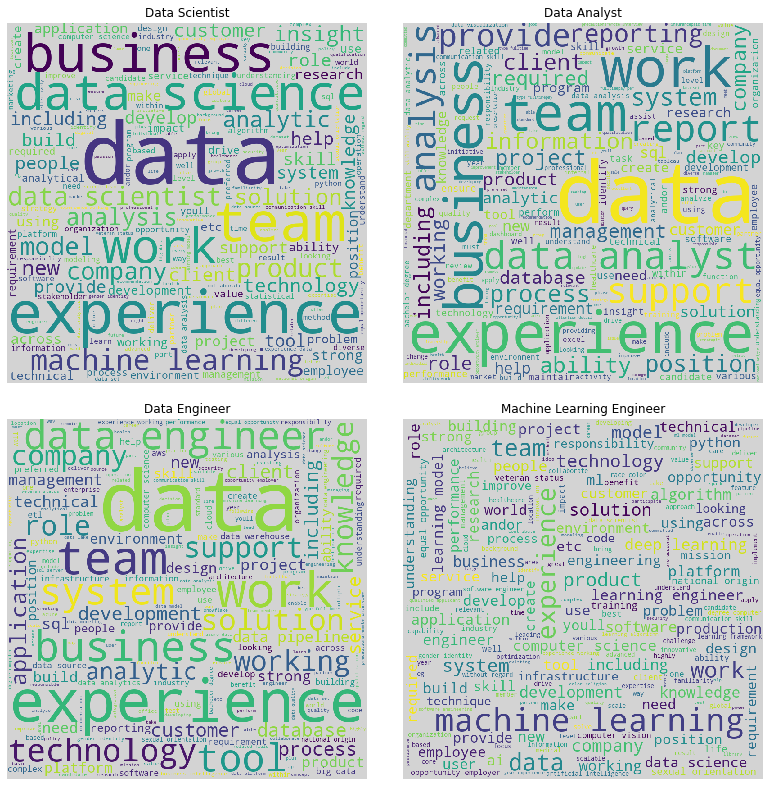

In [67]:
ds_cloud = WordCloud(background_color='lightgray', 
                      height=800, width=800).generate(' '.join(ds_words))

da_cloud = WordCloud(background_color='lightgray', 
                      height=800, width=800).generate(' '.join(da_words))

de_cloud = WordCloud(background_color='lightgray', 
                      height=800, width=800).generate(' '.join(de_words))

mle_cloud = WordCloud(background_color='lightgray', 
                      height=800, width=800).generate(' '.join(mle_words))

plt.figure(figsize=(10,10))
axs = [plt.axes([.25, 1, .5, .5]), 
       plt.axes([.8, 1, .5, .5]), 
       plt.axes([.25, .45, .5, .5]), 
       plt.axes([.8, .45, .5, .5])]

# imshow => display data as an image
axs[0].imshow(ds_cloud)
axs[1].imshow(da_cloud)
axs[2].imshow(de_cloud)
axs[3].imshow(mle_cloud)

axs[0].set_title('Data Scientist')
axs[1].set_title('Data Analyst')
axs[2].set_title('Data Engineer')
axs[3].set_title('Machine Learning Engineer')

for ax in axs: ax.axis('off')

# N-Grams
- n-word phrases to help identify which can be common in each job title

### Bi-Grams

In [74]:
all_bigrams = pd.Series(list(nltk.ngrams(all_words, 2))).value_counts()
ds_bigrams = pd.Series(list(nltk.ngrams(ds_words, 2))).value_counts()
da_bigrams = pd.Series(list(nltk.ngrams(da_words, 2))).value_counts()
de_bigrams = pd.Series(list(nltk.ngrams(de_words, 2))).value_counts()
mle_bigrams = pd.Series(list(nltk.ngrams(mle_words, 2))).value_counts()

In [73]:
all_bigrams.head(20)

(machine, learning)        1042
(data, science)             454
(data, scientist)           316
(computer, science)         308
(data, analyst)             245
(data, engineer)            238
(equal, opportunity)        217
(national, origin)          204
(sexual, orientation)       204
(data, analysis)            204
(deep, learning)            200
(communication, skill)      187
(opportunity, employer)     185
(data, pipeline)            178
(veteran, status)           175
(experience, working)       173
(data, analytics)           169
(gender, identity)          167
(bachelor, degree)          167
(data, set)                 153
dtype: int64

# Tri-Grams

In [75]:
all_trigrams = pd.Series(list(nltk.ngrams(all_words, 3))).value_counts()
ds_trigrams = pd.Series(list(nltk.ngrams(ds_words, 3))).value_counts()
da_trigrams = pd.Series(list(nltk.ngrams(da_words, 3))).value_counts()
de_trigrams = pd.Series(list(nltk.ngrams(de_words, 3))).value_counts()
mle_trigrams = pd.Series(list(nltk.ngrams(mle_words, 3))).value_counts()

In [77]:
all_trigrams.head(20)

(equal, opportunity, employer)          170
(without, regard, race)                 114
(sexual, orientation, gender)           114
(machine, learning, engineer)           110
(race, color, religion)                 108
(orientation, gender, identity)         105
(machine, learning, model)              103
(employment, without, regard)            98
(regard, race, color)                    97
(degree, computer, science)              90
(applicant, receive, consideration)      73
(qualified, applicant, receive)          73
(consideration, employment, without)     72
(receive, consideration, employment)     72
(data, science, team)                    69
(equal, employment, opportunity)         67
(protected, veteran, status)             61
(sex, sexual, orientation)               59
(color, religion, sex)                   55
(employer, qualified, applicant)         54
dtype: int64

# 4-grams

In [78]:
all_4grams = pd.Series(list(nltk.ngrams(all_words, 4))).value_counts()
ds_4grams = pd.Series(list(nltk.ngrams(ds_words, 4))).value_counts()
da_4grams = pd.Series(list(nltk.ngrams(da_words, 4))).value_counts()
de_4grams = pd.Series(list(nltk.ngrams(de_words, 4))).value_counts()
mle_4grams = pd.Series(list(nltk.ngrams(mle_words, 4))).value_counts()

In [80]:
all_4grams.head(20)

(sexual, orientation, gender, identity)                          105
(without, regard, race, color)                                    97
(regard, race, color, religion)                                   84
(employment, without, regard, race)                               79
(consideration, employment, without, regard)                      72
(qualified, applicant, receive, consideration)                    72
(receive, consideration, employment, without)                     71
(applicant, receive, consideration, employment)                   67
(race, color, religion, sex)                                      55
(sex, sexual, orientation, gender)                                49
(employer, qualified, applicant, receive)                         48
(equal, opportunity, employer, qualified)                         38
(opportunity, employer, qualified, applicant)                     38
(bachelor, degree, computer, science)                             36
(precautionsremote, interview, pro